# MLE Computation and Flat Priors

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import netCDF4 as nc4
import numpy as np
import pandas as pd
import logging

import pystan
import re
import time

In [2]:
# use test data (not all data is used for fitting/training)
use_testdata = False

# create plots of the data
show_data = True

# netCDF output file (set to None to not save output)
savename_output = '../results/zinser_results_flat.nc'

# save the Stan output instead a few stats (only active if filename is specified above)
save_stan_output = True

save_only_converged = False

# specify the Stan variable names to save; if set to None, all variables are saved 
# (only active if save_stan_output is True)
varnames_save = None

# the number of tries to fit each Stan model to achieve an R-hat < 1.1
num_tries = 3

# the number of chains to run
num_chains = 6

# the prior_only option passed to each Stan model
prior_only = False

# Number of days of data to fit
limit_days = 2

# Whether or not data limit is inclusive (include boundary point)
inclusive = False

# Whether to append dataset to itself to create a 96-hour dataset
# This option is used for validation experiments in rolling_window.ipynb
extend = False

# Whether to append results to an existing file or overwrite
append = False

## Load, Plot Data

In [3]:
# load processed data
datafile = '../data/size_distribution/zinser_processed.nc'

dataname = 'zinser'

desc = 'Culture dataset'

# Indices of data to hold out for hold-out validation
# Uncomment desired line and set use_testdata to true
itestfile = None
# itestfile = '../data/hold_out/keep_twothirds.csv'
# itestfile = '../data/hold_out/keep_half.csv'
# itestfile = '../data/hold_out/keep_onethird.csv'

size_units = 'fg C cell$^{-1}$'


def get_data(datafile, size_units, itestfile, dataname, desc, extend=False):
    
    data_gridded = {}
    with nc4.Dataset(datafile) as nc:
        for var in nc.variables:
            data_gridded[var] = nc.variables[var][:]

    # create "counts" entry
    if 'count' in data_gridded:
        data_gridded['counts'] = (data_gridded['count'][None,:]
                                  * data_gridded['w_obs']).astype(int)
    elif 'abundance' in data_gridded:
        logging.warning('Using "abundance" data to generate count data for the model.')
        data_gridded['counts'] = (data_gridded['count'][None,:]
                                  * data_gridded['w_obs']).astype(int)
    else:
        raise RuntimeError('Cannot find a "count" or "abundance" entry in "{}".'.format(datafile))
    
    # Appends the time series to itself to create a pseudo four-day dataset
    if extend:
        data_gridded['time'] = np.concatenate((data_gridded['time'],
                                               (data_gridded['time']
                                               + data_gridded['time'][-1]
                                               + data_gridded['time'][1])[:-1]))
        
        for item in ('w_obs', 'PAR', 'abundance', 'count', 'counts'):
            if len(data_gridded[item].shape) == 2:
                data_gridded[item] = np.concatenate((data_gridded[item],
                                                     data_gridded[item][:, 1:]), axis=1)
            else:
                data_gridded[item] = np.concatenate((data_gridded[item],
                                                     data_gridded[item][1:]))

    # add description
    desc += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded)
    
    return data_gridded, desc

data_gridded, desc = get_data(datafile, size_units, itestfile, dataname, desc, extend=extend)

/Users/kristof/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


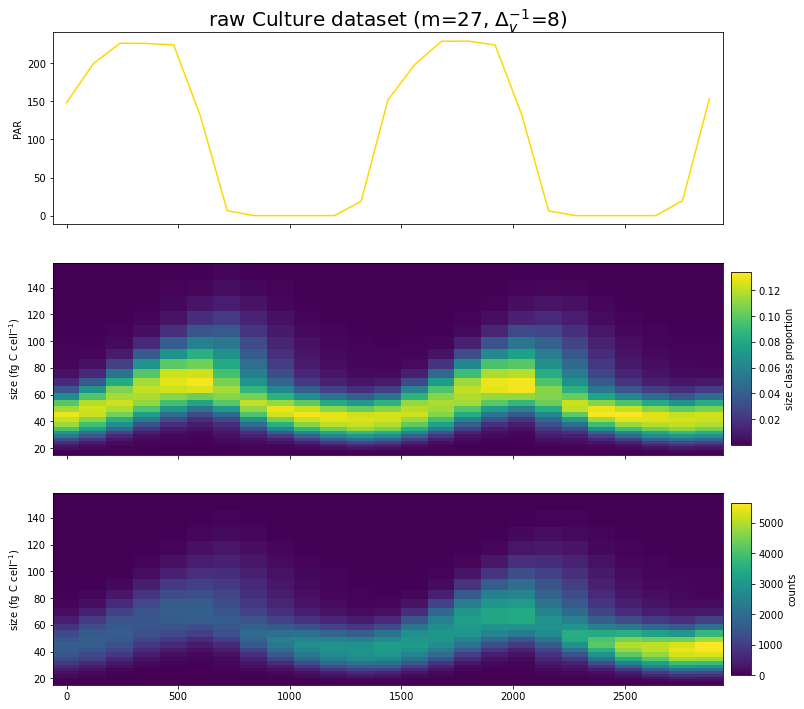

In [4]:
def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5,
                            bbox_to_anchor=(0.05,0.0,1,1),
                            bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical',
                              **cbarargs)

if show_data:
    nrows = 3

    v_min = data_gridded['v_min']
    delta_v = 1.0/data_gridded['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded['m'])*delta_v) 

    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    ax.set_title('raw '+desc, size=20)
    ax.plot(data_gridded['time'], data_gridded['PAR'], color='gold')
    ax.set(ylabel='PAR')

    ax = axs[1]
    pc = ax.pcolormesh(data_gridded['time'], v, data_gridded['w_obs'],
                       shading='auto')
    ax.set(ylabel='size ({})'.format(size_units))
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

    ax = axs[2]
    pc = ax.pcolormesh(data_gridded['time'], v, data_gridded['counts'],
                       shading='auto')
    ax.set(ylabel='size ({})'.format(size_units))
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
axs[-1].set_xlabel=('time (minutes)')
None

## Process and Re-plot Data

In [5]:
# prepare data for Stan model
def data_prep(data_gridded, dt=20, limit_days=2, start=0, use_testdata=False,
              itestfile=None, prior_only=False, inclusive=False):
    
    data = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[v] = data_gridded[v]

    data['obs'] = data_gridded['w_obs']
    data['t_obs'] = data_gridded['time']
    par = data_gridded['PAR']

    if limit_days > 0:
        limit_minutes = limit_days*1440

        if inclusive:
            ind_obs = (start*60 <= data['t_obs']) & (data['t_obs'] <= limit_minutes+start*60)
        else:
            ind_obs = (start*60 <= data['t_obs']) & (data['t_obs'] < limit_minutes+start*60)

        if not np.all(ind_obs):
            total = data['obs'].shape[1]
            remove = total - data['obs'][:, ind_obs].shape[1]
            print('start is set to {}, limit_days is set to {}, removing {}/{} observation times'.format(start,
                                                                                                         limit_days,
                                                                                                         remove,
                                                                                                         total))

        data['t_obs'] = data['t_obs'][ind_obs]
        data['obs'] = data['obs'][:,ind_obs]

        data['nt'] = int(limit_minutes//data['dt']+1)

    data['nt_obs'] = data['t_obs'].size

    if use_testdata:
        # load cross-validation testing indices and add them to data
        data['i_test'] = np.loadtxt(itestfile).astype(int)
        # remove last index, so that dimensions agree
        data['i_test'] = data['i_test'][:-1]
    else:
        # set all indices to zero
        data['i_test'] = np.zeros(data['nt_obs'], dtype=int)

    # switch on or off data fitting
    data['prior_only'] = int(prior_only)

    # add light data
    t = np.arange(data['nt'])*data['dt'] + start*60
    data['E'] = np.interp(t, xp=data_gridded['time'][ind_obs], fp=par[ind_obs])

    # real count data
    data['obs_count'] = data_gridded['counts'][:, ind_obs]
    
    data['start'] = start

    # consistency check
    if len(data['i_test']) != data['nt_obs']:
        raise ValueError('Invalid number of testing indices (expected {}, got {}).'.format(data['nt_obs'],
                                                                                       len(data['i_test'])))
    return data


data = data_prep(data_gridded, dt=20, limit_days=limit_days, start=0,
                 use_testdata=use_testdata, itestfile=itestfile,
                 prior_only=prior_only, inclusive=False)

start is set to 0, limit_days is set to 2, removing 1/25 observation times


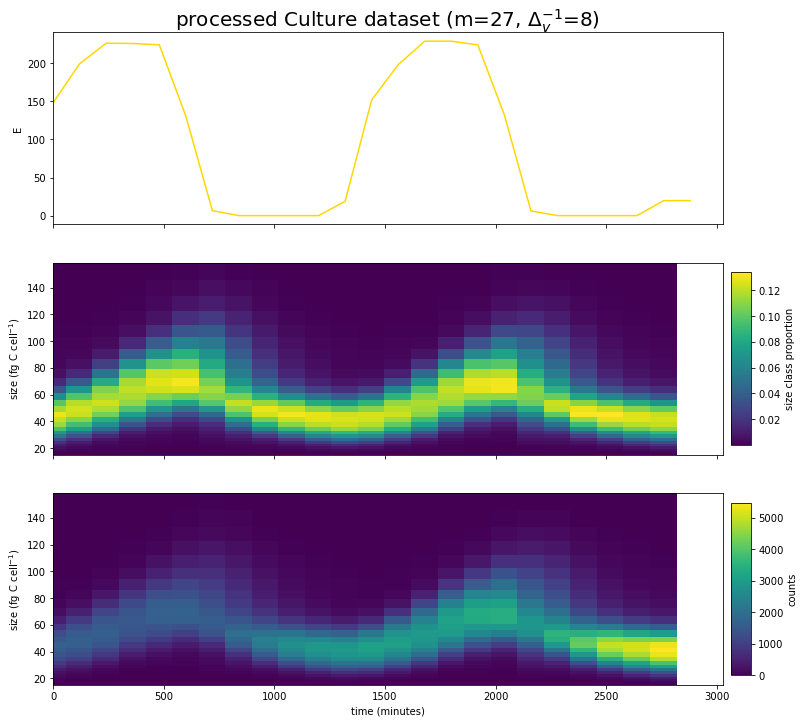

In [6]:
if show_data:
    nrows = 3

    v_min = data['v_min']
    delta_v = 1.0/data['delta_v_inv']
    v = v_min * 2**(np.arange(data['m'])*delta_v) 
    t = np.arange(data['nt'])*data['dt']


    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    ax.set_title('processed '+desc, size=20)
    ax.plot(t, data['E'], color='gold')
    ax.set(ylabel='E')

    ax = axs[1]
    pc = ax.pcolormesh(data['t_obs'], v, data['obs'], shading='auto')
    ax.set(ylabel='size ({})'.format(size_units))
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap,
                 label='size class proportion')
    ax.set_xlim(left=0.0)

    ax = axs[2]
    pc = ax.pcolormesh(data['t_obs'], v, data['obs_count'], shading='auto')
    ax.set(ylabel='size ({})'.format(size_units))
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')
None

## Choose models to fit

In [7]:
# Code files
stan_files = {
#     'm_bmx': '../stan_code/m_bmx.stan',
    'm_bmb': '../stan_code/m_bmb_mle.stan',
#     'm_pmb': '../stan_code/m_pmb.stan',
#     'm_fmb': '../stan_code/m_fmb.stan',
#     'm_fmf': '../stan_code/m_fmf.stan',
#     'm_btb': '../stan_code/m_btb.stan',
#     'm_ptb': '../stan_code/m_ptb.stan',
#     'm_ftb': '../stan_code/m_ftb.stan',
    'm_ftf': '../stan_code/m_ftf_mle.stan',
}

## Fit Models and Save Results

In [8]:
def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

if 'models' not in globals():
    models = {}
if 'num_tries' not in globals():
    num_tries = 3
    
try_again = True
refit_all = False

refit_required = {}
stan_base_code = {}
for key, stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for model in stan_files.keys():
    code_split = stan_base_code[model].split('\n')
    stan_code[model] = '\n'.join(code_split)

In [9]:
for model in stan_files.keys():
    refit_required[model] = True
    if model in models and models[model].model_code == stan_code[model]:
        print('{}: unchanged code, not recompiling'.format(model))
        refit_required[model] = False
    else:
        if model in models:
            print('{}: code change detected, recompiling'.format(model))
        else:
            print('{}: compiling'.format(model))
        models[model] = pystan.StanModel(model_code=stan_code[model],
                                         model_name=model,
                                         obfuscate_model_name=False)

mles = {}
for model in models:
    mle = models[model].optimizing(data=data)
    mles[model] = mle
    print(mles[model])
    print('\n\n\n')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_bmb NOW.


m_bmb: compiling
m_ftf: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_ftf NOW.


OrderedDict([('delta_incr', array([0.18353422, 0.23854298, 0.00739377, 0.04064743, 0.0159732 ,
       0.07169994, 0.01837994, 0.01325955, 0.07178665, 0.05665441,
       0.03752008, 0.01581347, 0.02524653, 0.10986133, 0.05590302,
       0.00719291, 0.01206602, 0.0145653 , 0.00395925])), ('delta_max', array(21.67341883)), ('gamma_max', array(2.55546221)), ('rho_max', array(3.32179892)), ('E_star', array(3692.00518687)), ('sigma', array(0.00030887)), ('theta', array([[7.77134528e-05, 7.00416156e-04, 3.03954861e-03, 5.45757918e-03,
        1.06674379e-02, 1.83081234e-02, 3.14765609e-02, 5.33699110e-02,
        7.24584894e-02, 9.57541822e-02, 1.14608955e-01, 1.22244356e-01,
        1.30191406e-01, 1.15388075e-01, 9.88772123e-02, 6.55214353e-02,
        3.52140210e-02, 1.46430969e-02, 5.30279860e-03, 2.18534856e-03,
        1.78623821e-03, 1.17576936e-03, 5.41068455e-04, 4.63590289e-04,
        1.60223048e-04, 8.52032755e-05, 3.01240119e-04],
       [1.52205244e-04, 3.71902705e-04, 1.1301610

In [10]:
for model in models:
    for itry in range(num_tries):
        t0 = time.time()
        mcmcs = models[model].sampling(data=data, iter=2000, chains=num_chains)
        sampling_time = time.time() - t0  # in seconds
        print('Model {} for {}-hour window starting at {} hours fit in {} minutes.'.format(model,
                                                                                           limit_days*24+2*int(inclusive),
                                                                                           data['start'],
                                                                                           np.round(sampling_time/60, 2)))
        # get max Rhat
        rhat_max = get_max_rhat(mcmcs)
        print('{}: in try {}/{} found Rhat={:.3f}'.format(model, itry+1, num_tries, rhat_max), end='')
        if rhat_max < 1.1 or itry == num_tries - 1:
            print()
            break
        print(', trying again')

    print('{}'.format(model)) 
    print('\n'.join(x for x in mcmcs.__str__().split('\n') if '[' not in x))
    print()
    
    if 'varnames_save' not in globals():
        varnames_save = None

    if savename_output is not None:
        if model == tuple(models.keys())[0] and append == False:
            mode = 'w'
        else:
            mode = 'a'
        with nc4.Dataset(savename_output, mode) as nc:
            ncm = nc.createGroup(model)

            # write model description
            ncm.setncattr('code', stan_files[model])

            if save_stan_output:
                if save_only_converged and get_max_rhat(mcmcs) > 1.1:
                    logging.warning('Model "{}" did not converge -- skipping.'.format(model))
                    continue
                dimensions = {
                    'obstime':int(data['nt_obs']),
                    'time':int(data['nt']),
                    'sizeclass':int(data['m']),
                    'm_minus_j_plus_1':int(data['m']-data['delta_v_inv']),
                    'm_minus_1':int(data['m']-1),
                    'knots_minus_1':int(6-1),  # hardcoded, adjust for varying nknots
                    'sample': mcmcs['mod_obspos'].shape[0],
                }
                dimensions_inv = {v:k for k,v in dimensions.items()}

                for d in dimensions:
                    if d not in ncm.dimensions:
                        ncm.createDimension(d, dimensions[d])

                if 'tau[1]' in mcmcs.flatnames:
                    dimensions['tau'] = mcmcs['tau'].shape[1]
                    dimensions_inv[dimensions['tau']] = 'tau'
                    if 'tau' not in ncm.dimensions:
                        ncm.createDimension('tau', dimensions['tau'])

                if 'time' not in ncm.variables:
                    ncm.createVariable('time', int, ('time',))
                ncm.variables['time'][:] = int(data['dt']) * np.arange(data['nt'])
                ncm.variables['time'].units = 'minutes since start of experiment'

                if 'obstime' not in ncm.variables:
                    ncm.createVariable('obstime', int, ('obstime',))
                ncm.variables['obstime'][:] = data['t_obs'].astype(int)
                ncm.variables['obstime'].units = 'minutes since start of experiment'
                ncm.variables['obstime'].long_name = 'time of observations'

                for v in ('dt', 'm', 'v_min', 'delta_v_inv', 'obs', 'i_test',
                          'E', 'obs_count'):
                    if isinstance(data[v], int):
                        if v not in ncm.variables:
                            ncm.createVariable(v, int, zlib=True)
                        ncm.variables[v][:] = data[v]
                    elif isinstance(data[v], float):
                        if v not in ncm.variables:
                            ncm.createVariable(v, float, zlib=True)
                        ncm.variables[v][:] = data[v]
                    else:
                        dims = tuple(dimensions_inv[d] for d in data[v].shape)
                        if v not in ncm.variables:
                            ncm.createVariable(v, data[v].dtype, dims, zlib=True)
                        ncm.variables[v][:] = data[v]


                varnames = set(v.split('[')[0] for v in mcmcs.flatnames)
                if varnames_save is None:
                    varnames_curr = varnames
                else:
                    varnames_curr = varnames_save

                for v in varnames_curr:
                    if v in varnames:
                        dims = tuple(dimensions_inv[d]
                                     for d in mcmcs[v].shape)
                        if v not in ncm.variables:
                            ncm.createVariable(v, float, dims, zlib=True)
                        ncm.variables[v][:] = mcmcs[v]
                    else:
                        logging.warning('Cannot find variable "{}" for model "{}".'.format(v,
                                                                                           model))
            else:
                if 'sample' not in ncm.dimensions:
                    ncm.createDimension('sample',
                                        mcmcs['divrate'].shape[0])

                if 'divrate' not in ncm.variables:
                    ncm.createVariable('divrate', float, ('sample'))

                if 'sumsqdiff' not in ncm.variables:
                    ncm.createVariable('sumsqdiff', float, ('sample'))

                ncm.variables['sumsqdiff'].setncattr('long_name',
                                                     'sum of squared column differences')

                ncm.variables['divrate'][:] = mcmcs['divrate']

                obs = data['obs']

                tmp = mcmcs['mod_obspos']
                tmp /= np.sum(tmp, axis=1)[:, None, :]
                tmp -= obs[None, :, :]
                tmp **= 2

                if np.all(data['i_test'] == 0):
                    ncm.variables['sumsqdiff'][:] = np.mean(np.sum(tmp, axis=1),
                                                              axis=1)
                    ncm.variables['sumsqdiff'].setncattr('data_used',
                                                         'all data')
                else:
                    ncm.variables['sumsqdiff'][:] = np.mean(np.sum(tmp[:, :, data['i_test'] == 1],
                                                                    axis=1), axis=1)
                    ncm.variables['sumsqdiff'].setncattr('data_used', 'testing data')

                for iv,v in enumerate(('gamma_max', 'rho_max', 'xi',
                                       'xir', 'E_star')):
                    if v not in ncm.variables:
                        ncm.createVariable(v, float, ('model','sample'))
                    if v in mcmcs.flatnames:
                        ncm.variables[v][:] = mcmcs[v]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Model m_bmb for 48-hour window starting at 0 hours fit in 33.15 minutes.
m_bmb: in try 1/3 found Rhat=1.002
m_bmb
Inference for Stan model: m_bmb.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                         mean se_mean      sd    2.5%      25%     50%     75%   97.5%  n_eff   Rhat
delta_max               49.68    0.17    9.76   32.28    42.55   49.13   56.56   68.88   3373    1.0
gamma_max                6.16  5.6e-3     0.3     5.4     5.99    6.25     6.4    6.51   2939    1.0
rho_max                  0.84  4.0e-4    0.03    0.79     0.82    0.84    0.86     0.9   5284    1.0
E_star                 263.84    0.41   22.35  211.35   250.84   267.1  279.64  299.24   2940    1.0
sigma                  348.61    0.24   19.78  310.87    334.9  348.33  361.87  387.41   6847    1.0
divrate                  0.62  2.9e-4    0.02    0.58     0.61    0.62    0.64    0.67   6489    1.0
lp__                   -1.4e

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
/Users/kristof/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/kristof/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:211: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Model m_ftf for 48-hour window starting at 0 hours fit in 11.99 minutes.
m_ftf: in try 1/3 found Rhat=65.491, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
/Users/kristof/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Model m_ftf for 48-hour window starting at 0 hours fit in 10.47 minutes.
m_ftf: in try 2/3 found Rhat=172.645, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Model m_ftf for 48-hour window starting at 0 hours fit in 10.38 minutes.
m_ftf: in try 3/3 found Rhat=295.158
m_ftf
Inference for Stan model: m_ftf.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                         mean se_mean      sd    2.5%      25%     50%     75%   97.5%  n_eff   Rhat
delta_max               43.42   13.99   24.25    1.11    29.07   48.21   63.73   70.78      3  58.25
gamma_mu                  inf     nan     inf 1.2e307  7.6e307 1.2e308 1.5e308 1.8e308    nan    nan
gamma_sigma               inf     nan     inf 1.5e307  4.8e307 1.0e308 1.6e308 1.8e308    nan    nan
rho_mu                    inf     nan     inf 1.6e307  8.6e307 1.1e308 1.5e308 1.8e308    nan    nan
rho_sigma                 inf     nan     inf 3.3e307  1.0e308 1.2e308 1.6e308 1.8e308    nan    nan
E_star                 3223.1  900.14  1559.5  476.17   2359.6  3550.7  4675.9  4704.2      3  154.2
sigma                    0